In [3]:
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_device", jax.devices()[3])

import jax.numpy as jnp
from KernelTools import make_block,eval_k,vectorize_kfunc,diagpart,get_selected_grad
from Kernels import get_gaussianRBF,get_centered_scaled_poly_kernel
from data_utils import build_xy_grid
from darcy_data import get_darcy_solver,sample_gp_function
from jax.random import PRNGKey as pkey
import matplotlib.pyplot as plt
from EquationModel import CholInducedRKHS,SharedOperatorPDEModel,InducedOperatorModel,AltCholInducedRKHS
from tqdm.auto import tqdm
from parabolic_data_utils import build_alpha_chebyshev
from data_utils import make_grids

In [4]:
num_functions = 20
samples_per_function = 10
collocation_grid_n = 16

obs_random_keys = jax.random.split(pkey(32),num_functions)
xy_obs = tuple(jax.random.uniform(key,(samples_per_function,2),minval = 0.,maxval = 1.) for key in obs_random_keys)


kernel_f = get_gaussianRBF(0.15)
key = pkey(10)
keys = jax.random.split(key,num_functions)
rhs_functions = tuple(
    sample_gp_function(subkey,kernel_f) for subkey in keys
)

grid = jnp.linspace(0,1,100)
x,y = jnp.meshgrid(grid,grid)
fine_grid = jnp.vstack([x.flatten(),y.flatten()]).T

def a(x):
    return 0.1 * jnp.exp(0.5 * jnp.sin(4*jnp.pi*x[0]*x[1]))

darcy_solve = get_darcy_solver(a,num_grid = 50,k_u = get_gaussianRBF(0.2))
u_true_functions = tuple([darcy_solve(f) for f in rhs_functions])

k_u = get_gaussianRBF(0.2)

single_grid = build_alpha_chebyshev([0,1],collocation_grid_n,1.)
xy_int,xy_bdy = make_grids(single_grid,single_grid)

xy_all = jnp.vstack([xy_int,xy_bdy])

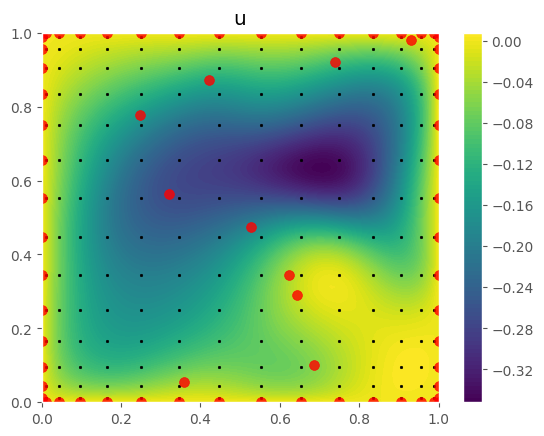

In [5]:
plt.title('u')
plt.tricontourf(fine_grid[:,0],fine_grid[:,1],jax.vmap(u_true_functions[0])(fine_grid),100)
plt.colorbar()
plt.scatter(xy_int[:,0],xy_int[:,1],c = 'black',s = 3)
plt.scatter(xy_obs[0][:,0],xy_obs[0][:,1],c = 'red',s = 50,alpha = 0.8)
plt.scatter(xy_bdy[:,0],xy_bdy[:,1],c = 'red',s = 50,alpha = 0.8)
plt.show()

In [6]:
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])
basis_operators = tuple([eval_k,diff_xx_op,diff_yy_op])
basis_operators = feature_operators


u_model = CholInducedRKHS(
    xy_all,
    basis_operators,
    k_u
)

observation_points = tuple(jnp.vstack([xy_bdy,obs]) for obs in xy_obs)
observation_values = tuple(jax.vmap(u)(obs_loc) for u,obs_loc in zip(u_true_functions,observation_points))
collocation_points = (xy_int,)*num_functions

rhs_values = tuple(jax.vmap(rhs_func)(int_points) for rhs_func,int_points in zip(rhs_functions,collocation_points))

all_u_params_init = tuple([
    u_model.get_fitted_params(obs_loc,obs_val) 
    for obs_loc,obs_val in zip(observation_points,observation_values)
    ]
    )

grid_features_u_init = [(
    u_model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
            len(xy_int),
            len(feature_operators),
            order = 'F'
        ) for model_params in all_u_params_init
        ]
grid_features_u_init = jnp.vstack([jnp.hstack([xy_int,features]) for features in grid_features_u_init])

num_P_inducing = 250
input_feature_sample = jax.random.choice(pkey(320),grid_features_u_init,(num_P_inducing,))
k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init[:,2:],c=1)
k_P_x_part = get_gaussianRBF(0.25)

def k_P(x,y):
    return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])

P_model = InducedOperatorModel(input_feature_sample,k_P)
P_init = P_model.get_fitted_params(grid_features_u_init,jnp.hstack(rhs_values),lam = 1e-4)

In [7]:
params_init = jnp.hstack(list(all_u_params_init)+[P_init])

u_init = jnp.stack(all_u_params_init)
EqnModel  = SharedOperatorPDEModel(
    P_model,
    u_model,
    observation_points,
    observation_values,
    collocation_points,
    feature_operators,
    rhs_values,
    datafit_weight = 10.,
    num_P_operator_params=num_P_inducing
)
beta_reg = 1e-12

In [8]:
import Optimizers
from importlib import reload
reload(Optimizers)

from Optimizers import CholeskyLM,BlockArrowLM,AlternatingLM,AndersonAlternatingLM,run_jaxopt
from Optimizers import LMParams,AltLMParams,AndersonAltLMParams
from jaxopt import LBFGS

In [9]:
def loss_fun(params):
    return EqnModel.loss(params) + (beta_reg/2)*jnp.sum(params**2)
jit_valgrad = jax.jit(jax.value_and_grad(loss_fun))
lbfgs = LBFGS(fun=jit_valgrad,value_and_grad = True, maxiter=10000,tol = 1e-6,history_size = 40)
lbfgs_sol,lbfgs_conv,state = run_jaxopt(lbfgs,params_init)

lm_params = LMParams(max_iter = 501,init_alpha = 1e-1)
arrow_u,arrow_P,arrow_conv = BlockArrowLM(
    u_init,P_init,EqnModel,beta_reg,beta_reg,
    optParams=lm_params
    )

alternating_params = AltLMParams(max_iter=501,init_alpha=1e-1)
alt_u,alt_P,alt_conv = AlternatingLM(u_init,P_init,EqnModel,beta_reg,beta_reg,alternating_params)

anderson_alternating_params = AndersonAltLMParams(
    alpha =  1e-6,
    AA_params={
        'maxiter':501,
        'history_size':20
    }
    )
ander_u,ander_P,ander_conv,state = AndersonAlternatingLM(u_init,P_init,EqnModel,beta_reg,beta_reg,anderson_alternating_params)

  0%|          | 0/10000 [00:00<?, ?it/s]

2024-11-03 23:07:29.618458: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce.323 = f64[20,196,256]{2,1,0} reduce(f64[20,196,256,2]{3,2,1,0} %broadcast.4285, f64[] %constant.5), dimensions={3}, to_apply=%region_24.566, metadata={op_name="jit(full_loss)/jit(main)/vmap(jit(single_function_residuals))/jit(single_eqn_features)/jit(evaluate_operators)/reduce_sum" source_file="/home/alexh/kernelequationlearning/keql_tools/Kernels.py" source_line=37}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-11-03 23:07:30.531777: E external/xla/xla/service/slow_operation_alarm.cc:133] The

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.06153, gradnorm = 0.4371, alpha = 0.08333, improvement_ratio = 0.9997
Iteration 1, loss = 0.03751, gradnorm = 0.08494, alpha = 0.06944, improvement_ratio = 1.052
Iteration 2, loss = 0.02676, gradnorm = 0.04221, alpha = 0.05787, improvement_ratio = 1.049
Iteration 3, loss = 0.02054, gradnorm = 0.02687, alpha = 0.04823, improvement_ratio = 1.043
Iteration 4, loss = 0.01646, gradnorm = 0.0188, alpha = 0.04019, improvement_ratio = 1.037
Iteration 5, loss = 0.01352, gradnorm = 0.01396, alpha = 0.03349, improvement_ratio = 1.033
Iteration 50, loss = 0.0001125, gradnorm = 0.0006968, alpha = 9.157e-06, improvement_ratio = 0.9866
Iteration 100, loss = 7.99e-06, gradnorm = 5.619e-06, alpha = 8.333e-07, improvement_ratio = 1.001
Iteration 150, loss = 5.78e-06, gradnorm = 7.706e-07, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 200, loss = 4.857e-06, gradnorm = 2.755e-07, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 250, loss = 4.325e-06, gradnorm = 1.585e-07, 

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.0588, u_gradnorm = 0.07656,  P_gradnorm = 0.01293, alpha = 0.075,
Iteration 1, loss = 0.03465, u_gradnorm = 0.03702,  P_gradnorm = 0.007807, alpha = 0.05625,
Iteration 2, loss = 0.02405, u_gradnorm = 0.02367,  P_gradnorm = 0.005122, alpha = 0.04219,
Iteration 3, loss = 0.01808, u_gradnorm = 0.01697,  P_gradnorm = 0.003586, alpha = 0.03164,
Iteration 4, loss = 0.01423, u_gradnorm = 0.01328,  P_gradnorm = 0.002668, alpha = 0.02373,
Iteration 5, loss = 0.01148, u_gradnorm = 0.01109,  P_gradnorm = 0.002062, alpha = 0.0178,
Iteration 50, loss = 0.0002195, u_gradnorm = 0.0007499,  P_gradnorm = 9.898e-09, alpha = 4.247e-08,
Iteration 100, loss = 0.0001176, u_gradnorm = 0.0004158,  P_gradnorm = 8.746e-10, alpha = 7.5e-09,
Iteration 150, loss = 8.325e-05, u_gradnorm = 0.0002973,  P_gradnorm = 5.657e-10, alpha = 7.5e-09,
Iteration 200, loss = 6.456e-05, u_gradnorm = 0.0002385,  P_gradnorm = 4.039e-10, alpha = 7.5e-09,
Iteration 250, loss = 5.281e-05, u_gradnorm = 0.0002072,

  0%|          | 0/501 [00:00<?, ?it/s]

In [18]:
convergence_results = {
    'lbfgs': lbfgs_conv,
    'Arrow LM': arrow_conv,
    "Alternating LM": alt_conv,
    "AA Alternating": ander_conv
}

## Comment on convergence plot

The relatively slower initial convergence of the ArrowLM algorithm is due to less aggressive stepsize adaptivation (reducing alpha by a factor of (1/1.2) rather than 0.75 on each good step)

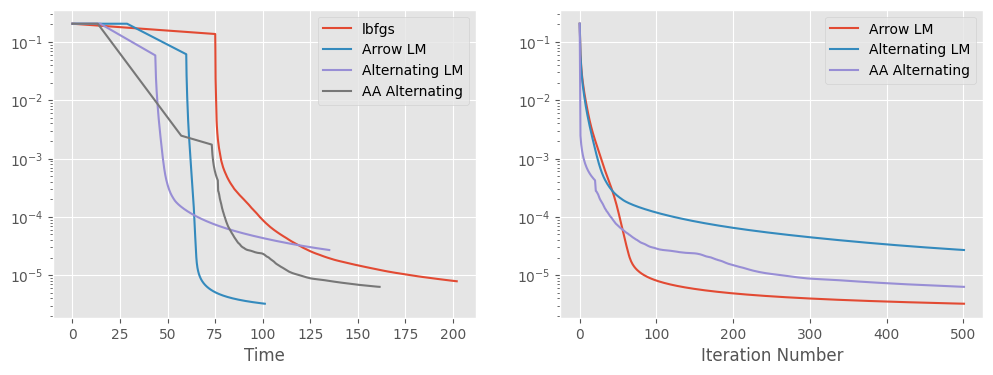

In [20]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
for name,c in convergence_results.items():
    times = c.cumulative_time
    plt.plot(jnp.hstack([0,times]),jnp.hstack([c.loss_vals[0],c.loss_vals]),label = name)
plt.legend()
plt.yscale('log')
plt.xlabel("Time")
plt.subplot(1,2,2)
for name,c in convergence_results.items():
    if name!='lbfgs':
        plt.plot(c.loss_vals,label = name)
plt.legend()
plt.yscale('log')
plt.xlabel("Iteration Number")
plt.show()


In [21]:
u_sol = arrow_u
P_sol = arrow_P

grid = jnp.linspace(0.0001,0.999,50)
x,y = jnp.meshgrid(grid,grid)
fine_grid_int = jnp.vstack([x.flatten(),y.flatten()]).T

eqnFeatures = EqnModel.single_eqn_features(u_sol[0],fine_grid_int)
Phat_uhat = P_model.predict(eqnFeatures,P_sol)
jnp.linalg.norm(jax.vmap(rhs_functions[0])(fine_grid_int) - Phat_uhat)/jnp.linalg.norm(jax.vmap(rhs_functions[0])(fine_grid_int))

Array(0.00822993, dtype=float64)

In [22]:
def get_percent_errors(u_params):
    #Have to loop since u_true_functions are just callables
    percent_errors = []
    for i in range(num_functions):
        u_vals = u_model.point_evaluate(fine_grid_int,u_params[i])
        u_true_vals = jax.vmap(u_true_functions[i])(fine_grid_int)
        percent_errors.append(jnp.linalg.norm(u_vals - u_true_vals)/jnp.linalg.norm(u_true_vals))
    percent_errors = jnp.array(percent_errors)
    return percent_errors

onestep_errors = get_percent_errors(u_sol)
interp_errors = get_percent_errors(u_init)
print(jnp.mean(onestep_errors))
print(jnp.mean(interp_errors))

0.0652760221836378
0.4133702355801804


In [23]:
jnp.mean(interp_errors/onestep_errors)

Array(6.19342471, dtype=float64)

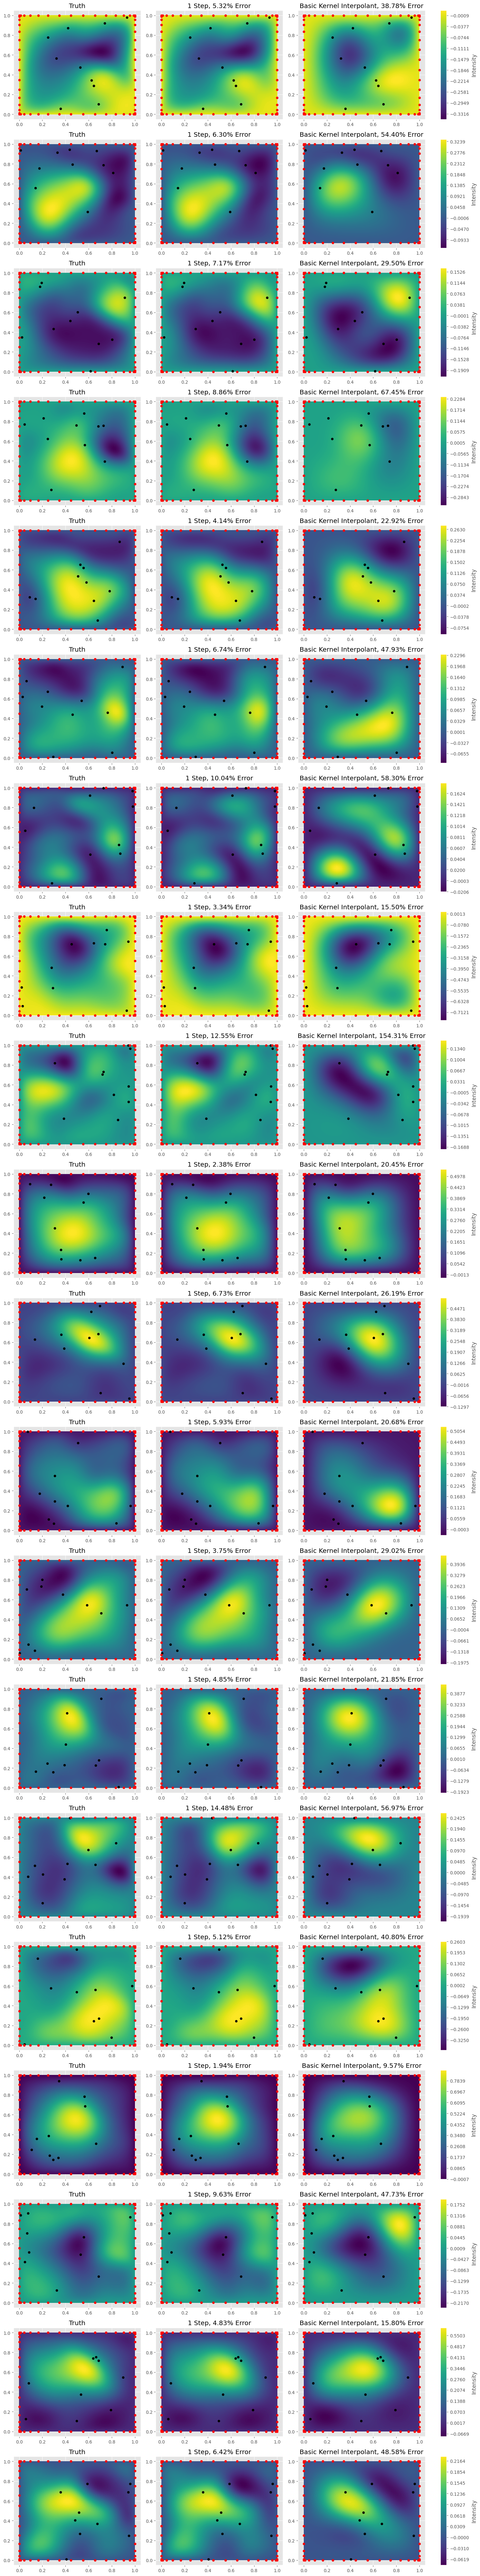

In [24]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15, 4 * num_functions))
gs = gridspec.GridSpec(num_functions, 4, width_ratios=[1, 1, 1, 0.05])  # Last column for colorbar

for i in range(num_functions):
    # Get the subplots for this row
    ax1 = plt.subplot(gs[i, 0])
    ax2 = plt.subplot(gs[i, 1])
    ax3 = plt.subplot(gs[i, 2])
    cbar_ax = plt.subplot(gs[i, 3])  # Colorbar axis

    # Compute the values
    u_vals_1step = u_model.point_evaluate(fine_grid_int, u_sol[i])
    u_vals_interp = u_model.point_evaluate(fine_grid_int, u_init[i])
    u_true_vals = jax.vmap(u_true_functions[i])(fine_grid_int)

    # Determine the levels for consistent color mapping across subplots in the same row
    lower = jnp.min(jnp.vstack([u_vals_1step, u_vals_interp, u_true_vals]))
    upper = jnp.max(jnp.vstack([u_vals_1step, u_vals_interp, u_true_vals]))
    levels = jnp.linspace(lower, upper + 1e-4, 200)

    # First subplot: Truth
    ax1.set_title("Truth")
    contour_truth = ax1.tricontourf(fine_grid_int[:, 0], fine_grid_int[:, 1], u_true_vals, levels=levels)
    ax1.scatter(xy_obs[i][:, 0], xy_obs[i][:, 1], c='black', s=25)
    ax1.scatter(xy_bdy[:, 0], xy_bdy[:, 1], c='red', s=25)

    # Second subplot: 1 Step Solution
    ax2.set_title(f"1 Step, {100 * onestep_errors[i]:.2f}% Error")
    contour_1step = ax2.tricontourf(fine_grid_int[:, 0], fine_grid_int[:, 1], u_vals_1step, levels=levels)
    ax2.scatter(xy_obs[i][:, 0], xy_obs[i][:, 1], c='black', s=25)
    ax2.scatter(xy_bdy[:, 0], xy_bdy[:, 1], c='red', s=25)

    # Third subplot: Basic Kernel Interpolant
    ax3.set_title(f"Basic Kernel Interpolant, {100 * interp_errors[i]:.2f}% Error")
    contour_interp = ax3.tricontourf(fine_grid_int[:, 0], fine_grid_int[:, 1], u_vals_interp, levels=levels)
    ax3.scatter(xy_obs[i][:, 0], xy_obs[i][:, 1], c='black', s=25)
    ax3.scatter(xy_bdy[:, 0], xy_bdy[:, 1], c='red', s=25)

    # Add colorbar for this row
    cbar = fig.colorbar(contour_interp, cax=cbar_ax)
    cbar_ax.set_ylabel('Intensity')  # Label for colorbar

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



In [136]:
evaluation_key = pkey(10)
num_evaluation_functions = 5
kernel_f = get_gaussianRBF(0.15)
keys = jax.random.split(key,num_evaluation_functions)

rhs_functions_eval = tuple(
    sample_gp_function(subkey,kernel_f) for subkey in keys
)

grid = jnp.linspace(0,1,100)
x,y = jnp.meshgrid(grid,grid)
fine_grid = jnp.vstack([x.flatten(),y.flatten()]).T

def a(x):
    return 0.1 * jnp.exp(0.5 * jnp.sin(4*jnp.pi*x[0]*x[1]))

darcy_solve = get_darcy_solver(a,num_grid = 50,k_u = get_gaussianRBF(0.2))
u_true_functions = tuple([darcy_solve(f) for f in rhs_functions])

k_u = get_gaussianRBF(0.2)

single_grid = build_alpha_chebyshev([0,1],collocation_grid_n,1.)
xy_int,xy_bdy = make_grids(single_grid,single_grid)

xy_all = jnp.vstack([xy_int,xy_bdy])


In [ ]:
from functools import partial

class PDEModel():
    def __init__(
        self,
        kernel,
        vec_P_function,
        feature_operators,
        num_grid = 50,
        bdy_weight = 10,
        solverParams = LMParams(max_iter = 501,min_alpha = 1e-8)
        ) -> None:
        self.solverParams = solverParams
        self.kernel = kernel
        self.vec_P_function = vec_P_function
        self.feature_operators = feature_operators
        self.num_grid = num_grid
        self.bdy_weight = bdy_weight

        point_grid = build_alpha_chebyshev([0,1],self.num_grid,1.)
        self.xy_int,self.xy_bdy = make_grids(point_grid,point_grid)
        self.u_model = CholInducedRKHS(jnp.vstack([self.xy_int,self.xy_bdy]),feature_operators,kernel) 

    def input_features(
        self,
        u_params,
        evaluation_points,
        ):
        """
        Computes features as input to P_operator_model
        """
        num_points = len(evaluation_points)
        num_ops = len(self.feature_operators)
        op_evaluation = self.u_model.evaluate_operators(self.feature_operators,evaluation_points,u_params)
        u_op_features = op_evaluation.reshape(num_points,num_ops,order = 'F')
        full_features = jnp.hstack([evaluation_points,u_op_features])
        return full_features
    
    @partial(jax.jit,static_argnames = ['self'])
    def F(self,u_params,rhs_values,bdy_values):
        P_features = self.input_features(u_params,self.xy_int)
        pde_residual = rhs_values - self.vec_P_function(P_features)
        u_bdy_values = self.u_model.point_evaluate(self.xy_bdy,u_params)
        bdy_residual = jnp.sqrt(self.bdy_weight)*(bdy_values - u_bdy_values)
        return jnp.hstack([pde_residual/jnp.sqrt(len(pde_residual)),bdy_residual/jnp.sqrt(len(bdy_residual))])
    
    @partial(jax.jit, static_argnames=['self'])
    def jac(self,u_params,rhs_values,bdy_values):
        """This is to allow for custom jacobian operators, and a choice
        between forward and reverse mode autodiff.
        In particular, we may want batched map based JVP
        """
        return jax.jacrev(self.F,argnums = 0)(u_params,rhs_values,bdy_values)
    
    def damping_matrix(self,u_params):
        return jnp.identity(len(u_params))
    
    def solve(self,rhs_function,bdy_function = lambda x:0):
        rhs_values = jax.vmap(rhs_function)(self.xy_int)
        bdy_values = jax.vmap(bdy_function)(self.xy_bdy)
        class pde():
            def __init__(
                self,
                rhs_values,
                bdy_values,
                main_model = self
                ) -> None:
                self.main_model = main_model
                self.rhs_values = rhs_values
                self.bdy_values = bdy_values

            def F(self,u_params):
                return self.main_model.F(u_params,self.rhs_values,self.bdy_values)
            
            def jac(self,u_params):
                return self.main_model.jac(u_params,self.rhs_values,self.bdy_values)
            
            def damping_matrix(self,u_params):
                return self.main_model.damping_matrix(u_params)

        u_init = jnp.zeros(self.u_model.num_params)
        u_sol,conv_data = CholeskyLM(u_init,pde(rhs_values,bdy_values),1e-14,self.solverParams)
        return self.u_model,u_sol,conv_data

In [138]:
P_function = lambda input_vals: P_model.predict(input_vals,P_sol)
pdemodel = PDEModel(
    k_u,
    P_function,
    feature_operators,
    num_grid = 25
    )

two_step_P_function = lambda input_vals: P_model.predict(input_vals,P_init)
pdemodel_twostep = PDEModel(
    k_u,
    two_step_P_function,
    feature_operators,
    num_grid = 25
    )

In [139]:
operator_errors = []
two_step_operator_errors = []
for i in range(num_evaluation_functions):
    pde_u_model,u_pde_params,pde_conv = pdemodel.solve(rhs_function = rhs_functions_eval[i])
    op_learn_new = pde_u_model.point_evaluate(fine_grid_int,u_pde_params)
    true_new = jax.vmap(darcy_solve(rhs_functions_eval[i]))(fine_grid_int)
    operator_errors.append(jnp.linalg.norm(op_learn_new- true_new)/jnp.linalg.norm(true_new))

    pde_u_model,u_pde_params,pde_conv = pdemodel_twostep.solve(rhs_function = rhs_functions_eval[i])
    op_learn_new = pde_u_model.point_evaluate(fine_grid_int,u_pde_params)
    two_step_operator_errors.append(jnp.linalg.norm(op_learn_new- true_new)/jnp.linalg.norm(true_new))

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.3136, gradnorm = 1.999, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 0.1702, gradnorm = 0.9308, alpha = 2.083, improvement_ratio = 1.0
Iteration 2, loss = 0.1056, gradnorm = 0.5155, alpha = 1.736, improvement_ratio = 1.0
Iteration 3, loss = 0.0707, gradnorm = 0.3272, alpha = 1.447, improvement_ratio = 1.0
Iteration 4, loss = 0.04996, gradnorm = 0.2236, alpha = 1.206, improvement_ratio = 1.0
Iteration 5, loss = 0.03688, gradnorm = 0.1588, alpha = 1.005, improvement_ratio = 1.0
Iteration 50, loss = 0.0001779, gradnorm = 8.42e-05, alpha = 0.0002747, improvement_ratio = 1.0
Iteration 100, loss = 3.551e-06, gradnorm = 6.486e-08, alpha = 3.019e-08, improvement_ratio = 1.0


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.2031, gradnorm = 3.762, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 0.1188, gradnorm = 0.8654, alpha = 2.083, improvement_ratio = 1.0
Iteration 2, loss = 0.08675, gradnorm = 0.3762, alpha = 1.736, improvement_ratio = 1.0
Iteration 3, loss = 0.06892, gradnorm = 0.2297, alpha = 1.447, improvement_ratio = 1.0
Iteration 4, loss = 0.05729, gradnorm = 0.1615, alpha = 1.206, improvement_ratio = 1.0
Iteration 5, loss = 0.04916, gradnorm = 0.1206, alpha = 1.005, improvement_ratio = 1.0
Iteration 50, loss = 0.004369, gradnorm = 0.0002074, alpha = 0.0002747, improvement_ratio = 1.0
Iteration 100, loss = 0.002559, gradnorm = 8.563e-07, alpha = 3.019e-08, improvement_ratio = 1.0
Iteration 150, loss = 0.002161, gradnorm = 1.539e-07, alpha = 8.333e-09, improvement_ratio = 1.0
Iteration 200, loss = 0.002095, gradnorm = 9.02e-08, alpha = 8.333e-09, improvement_ratio = 1.0
Iteration 250, loss = 0.002066, gradnorm = 6.781e-08, alpha = 8.333e-09, improvement_ratio = 1.0


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.2009, gradnorm = 1.867, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 0.1179, gradnorm = 0.7498, alpha = 2.083, improvement_ratio = 1.0
Iteration 2, loss = 0.08272, gradnorm = 0.3852, alpha = 1.736, improvement_ratio = 1.0
Iteration 3, loss = 0.06294, gradnorm = 0.2415, alpha = 1.447, improvement_ratio = 1.0
Iteration 4, loss = 0.04991, gradnorm = 0.1702, alpha = 1.206, improvement_ratio = 1.0
Iteration 5, loss = 0.04049, gradnorm = 0.1281, alpha = 1.005, improvement_ratio = 1.0
Iteration 50, loss = 8.599e-05, gradnorm = 6.147e-05, alpha = 0.0002747, improvement_ratio = 1.0
Iteration 100, loss = 1.565e-06, gradnorm = 5.127e-08, alpha = 3.019e-08, improvement_ratio = 1.0


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.1261, gradnorm = 3.483, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 0.07814, gradnorm = 0.6932, alpha = 2.083, improvement_ratio = 1.0
Iteration 2, loss = 0.05965, gradnorm = 0.2816, alpha = 1.736, improvement_ratio = 1.0
Iteration 3, loss = 0.0488, gradnorm = 0.1757, alpha = 1.447, improvement_ratio = 1.0
Iteration 4, loss = 0.04125, gradnorm = 0.127, alpha = 1.206, improvement_ratio = 1.0
Iteration 5, loss = 0.03555, gradnorm = 0.09818, alpha = 1.005, improvement_ratio = 1.0
Iteration 50, loss = 0.005654, gradnorm = 0.0001752, alpha = 0.0002747, improvement_ratio = 1.0
Iteration 100, loss = 0.003627, gradnorm = 7.573e-07, alpha = 3.019e-08, improvement_ratio = 1.0
Iteration 150, loss = 0.003412, gradnorm = 1.093e-07, alpha = 8.333e-09, improvement_ratio = 1.0
Iteration 200, loss = 0.003371, gradnorm = 7.947e-08, alpha = 8.333e-09, improvement_ratio = 1.0
Iteration 250, loss = 0.003345, gradnorm = 6.684e-08, alpha = 8.333e-09, improvement_ratio = 1.0

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.2537, gradnorm = 2.514, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 0.1269, gradnorm = 0.9605, alpha = 2.083, improvement_ratio = 1.0
Iteration 2, loss = 0.07979, gradnorm = 0.4678, alpha = 1.736, improvement_ratio = 1.0
Iteration 3, loss = 0.05714, gradnorm = 0.2735, alpha = 1.447, improvement_ratio = 1.0
Iteration 4, loss = 0.04442, gradnorm = 0.178, alpha = 1.206, improvement_ratio = 1.0
Iteration 5, loss = 0.03648, gradnorm = 0.1239, alpha = 1.005, improvement_ratio = 1.0
Iteration 50, loss = 0.0001386, gradnorm = 8.776e-05, alpha = 0.0002747, improvement_ratio = 1.0
Iteration 100, loss = 2.953e-06, gradnorm = 6.765e-08, alpha = 3.019e-08, improvement_ratio = 1.0


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.1679, gradnorm = 4.004, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 0.1127, gradnorm = 0.7329, alpha = 2.083, improvement_ratio = 1.0
Iteration 2, loss = 0.08872, gradnorm = 0.3071, alpha = 1.736, improvement_ratio = 1.0
Iteration 3, loss = 0.07319, gradnorm = 0.2037, alpha = 1.447, improvement_ratio = 1.0
Iteration 4, loss = 0.062, gradnorm = 0.1533, alpha = 1.206, improvement_ratio = 1.0
Iteration 5, loss = 0.0536, gradnorm = 0.1196, alpha = 1.005, improvement_ratio = 1.0
Iteration 50, loss = 0.004987, gradnorm = 0.0002377, alpha = 0.0002747, improvement_ratio = 1.0
Iteration 100, loss = 0.002796, gradnorm = 9.033e-07, alpha = 3.019e-08, improvement_ratio = 1.0
Iteration 150, loss = 0.002555, gradnorm = 1.001e-07, alpha = 8.333e-09, improvement_ratio = 1.0
Iteration 200, loss = 0.002524, gradnorm = 6.382e-08, alpha = 8.333e-09, improvement_ratio = 1.0
Iteration 250, loss = 0.00251, gradnorm = 4.565e-08, alpha = 8.333e-09, improvement_ratio = 1.0
Ite

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.2469, gradnorm = 1.803, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 0.1574, gradnorm = 0.7511, alpha = 2.083, improvement_ratio = 1.0
Iteration 2, loss = 0.1152, gradnorm = 0.407, alpha = 1.736, improvement_ratio = 1.0
Iteration 3, loss = 0.08918, gradnorm = 0.2685, alpha = 1.447, improvement_ratio = 1.0
Iteration 4, loss = 0.07076, gradnorm = 0.1972, alpha = 1.206, improvement_ratio = 1.0
Iteration 5, loss = 0.0567, gradnorm = 0.1536, alpha = 1.005, improvement_ratio = 1.0
Iteration 50, loss = 0.0001047, gradnorm = 7.863e-05, alpha = 0.0002747, improvement_ratio = 1.0
Iteration 100, loss = 1.877e-06, gradnorm = 5.919e-08, alpha = 3.019e-08, improvement_ratio = 1.0


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.1802, gradnorm = 3.177, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 0.1205, gradnorm = 0.658, alpha = 2.083, improvement_ratio = 1.0
Iteration 2, loss = 0.0895, gradnorm = 0.3358, alpha = 1.736, improvement_ratio = 1.0
Iteration 3, loss = 0.06977, gradnorm = 0.2326, alpha = 1.447, improvement_ratio = 1.0
Iteration 4, loss = 0.05632, gradnorm = 0.1715, alpha = 1.206, improvement_ratio = 1.0
Iteration 5, loss = 0.04679, gradnorm = 0.1301, alpha = 1.005, improvement_ratio = 1.0
Iteration 50, loss = 0.002724, gradnorm = 0.0002175, alpha = 0.0002747, improvement_ratio = 1.0
Iteration 100, loss = 0.000682, gradnorm = 5.959e-07, alpha = 3.019e-08, improvement_ratio = 1.0
Iteration 150, loss = 0.0005646, gradnorm = 7.521e-08, alpha = 8.333e-09, improvement_ratio = 1.0
Iteration 200, loss = 0.0005483, gradnorm = 4.638e-08, alpha = 8.333e-09, improvement_ratio = 1.0
Iteration 250, loss = 0.0005404, gradnorm = 3.599e-08, alpha = 8.333e-09, improvement_ratio = 1.

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.1748, gradnorm = 1.977, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 0.08574, gradnorm = 0.8097, alpha = 2.083, improvement_ratio = 1.0
Iteration 2, loss = 0.05229, gradnorm = 0.3908, alpha = 1.736, improvement_ratio = 1.0
Iteration 3, loss = 0.03533, gradnorm = 0.2321, alpha = 1.447, improvement_ratio = 1.0
Iteration 4, loss = 0.0255, gradnorm = 0.1551, alpha = 1.206, improvement_ratio = 1.0
Iteration 5, loss = 0.0194, gradnorm = 0.1091, alpha = 1.005, improvement_ratio = 1.0
Iteration 50, loss = 7.984e-05, gradnorm = 6.483e-05, alpha = 0.0002747, improvement_ratio = 1.0
Iteration 100, loss = 1.624e-06, gradnorm = 5.856e-08, alpha = 3.019e-08, improvement_ratio = 1.0


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.1494, gradnorm = 3.661, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 0.09123, gradnorm = 0.6953, alpha = 2.083, improvement_ratio = 1.0
Iteration 2, loss = 0.0641, gradnorm = 0.3254, alpha = 1.736, improvement_ratio = 1.0
Iteration 3, loss = 0.04863, gradnorm = 0.2144, alpha = 1.447, improvement_ratio = 1.0
Iteration 4, loss = 0.03925, gradnorm = 0.1494, alpha = 1.206, improvement_ratio = 1.0
Iteration 5, loss = 0.03328, gradnorm = 0.107, alpha = 1.005, improvement_ratio = 1.0
Iteration 50, loss = 0.002671, gradnorm = 0.0002007, alpha = 0.0002747, improvement_ratio = 1.0
Iteration 100, loss = 0.001111, gradnorm = 4.438e-07, alpha = 3.019e-08, improvement_ratio = 1.0
Iteration 150, loss = 0.001036, gradnorm = 5.43e-08, alpha = 8.333e-09, improvement_ratio = 1.0
Iteration 200, loss = 0.001027, gradnorm = 3.623e-08, alpha = 8.333e-09, improvement_ratio = 1.0
Iteration 250, loss = 0.001021, gradnorm = 2.881e-08, alpha = 8.333e-09, improvement_ratio = 1.0
I

In [2]:
operator_errors

NameError: name 'operator_errors' is not defined

In [1]:
two_step_operator_errors

NameError: name 'two_step_operator_errors' is not defined